# Setting up a class for converting features into joint probability space

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import ps.joint_probability as psjp
import ps.utility as psu

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
train = pd.read_csv('train.csv', header=0)
probas = pd.read_csv('./data/cond_proba_space.csv')

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = psu.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

In [4]:
probas.columns

Index(['ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat',
       'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03',
       'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03'],
      dtype='object')

In [20]:
probas.head()

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03
0,1.000942,1.002469,0.999215,0.998197,1.006565,0.987045,1.140953,1.299123,0.970069,1.020198,...,1.046285,0.937280,1.141674,1.007003,1.049128,0.995984,0.860137,1.056189,0.825299,0.954400
1,1.000942,1.002469,0.999215,0.998197,0.987755,1.002346,1.140953,0.896517,1.152664,1.020198,...,0.803583,0.942272,0.815322,0.924580,1.133283,0.995984,1.083735,1.064549,0.986359,0.983678
2,1.000942,1.002469,0.999215,0.998197,0.987755,1.002346,1.140953,0.896517,1.152664,1.020198,...,0.821368,0.948083,1.068257,1.111436,0.995839,0.995984,0.841713,1.042805,0.885852,0.779018
3,1.000942,0.995834,1.000975,0.998197,1.006565,1.002346,0.782969,0.896517,0.970069,1.020198,...,0.751776,1.007688,0.737108,0.911950,0.843828,0.995984,0.989755,1.127504,0.825299,0.890997
4,1.000942,0.995834,1.000975,1.004475,0.987755,1.002346,0.782969,0.896517,0.970069,1.020198,...,0.768783,0.937597,0.737108,0.911950,1.460846,0.995984,0.886947,1.056189,1.149334,1.034074


In [5]:
num_samples = len(target)
num_target = np.sum(target)
freq_target = num_target/num_samples
freq_target

0.036447517859182946

In [6]:
ind_bins_fs = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
               'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin',
               'ps_ind_18_bin']
ind_bins = train[ind_bins_fs]
ind_bins_probas = probas[ind_bins_fs]

In [7]:
jp = psjp.JointProbability()
jp.fit(ind_bins, target, label='ind_bin_proba')
res1 = jp.transform(ind_bins, label='ind_bin_proba')

In [8]:
res1.head()

0    0.072793
1    0.038061
2    0.033978
3    0.026372
4    0.026372
Name: ind_bin_proba, dtype: float64

In [9]:
X = np.array(ind_bins_probas)
y1 = np.array(res1)
y = np.array(target)

In [10]:
pca = PCA()
Xpca = pca.fit_transform(X)

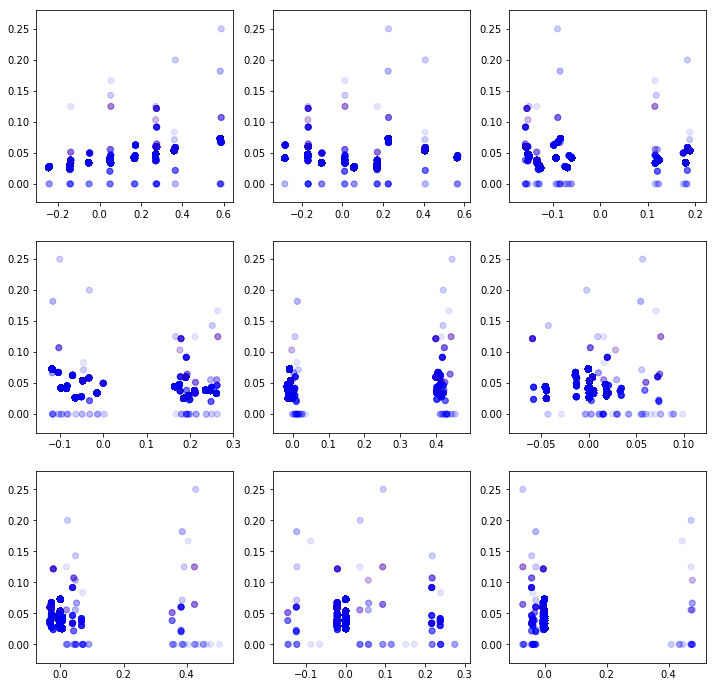

In [11]:
num_pts = 100000
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
ax1.scatter(Xpca[:num_pts, 0], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:num_pts, 1], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:num_pts, 2], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:num_pts, 3], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:num_pts, 4], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax6.scatter(Xpca[:num_pts, 5], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax7.scatter(Xpca[:num_pts, 6], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax8.scatter(Xpca[:num_pts, 7], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax9.scatter(Xpca[:num_pts, 8], y1[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)

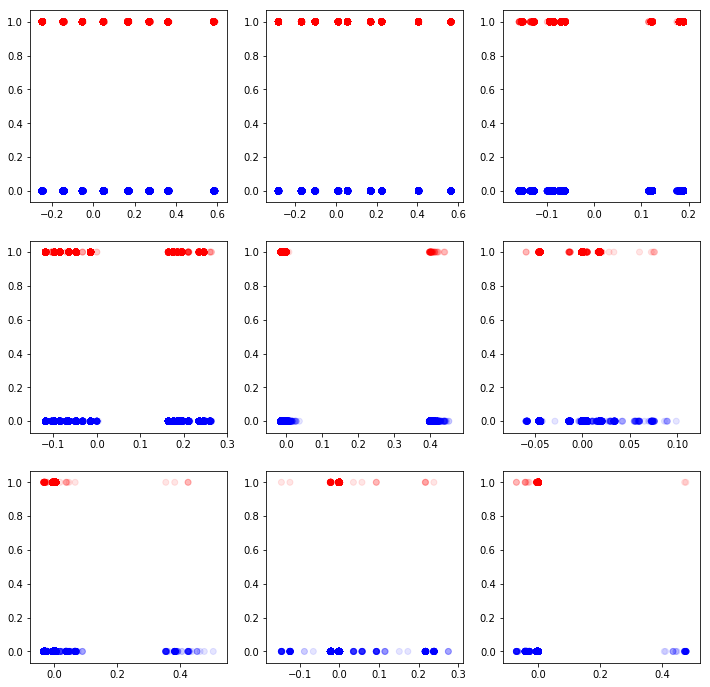

In [12]:
num_pts = 100000
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
ax1.scatter(Xpca[:num_pts, 0], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:num_pts, 1], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:num_pts, 2], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:num_pts, 3], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:num_pts, 4], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax6.scatter(Xpca[:num_pts, 5], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax7.scatter(Xpca[:num_pts, 6], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax8.scatter(Xpca[:num_pts, 7], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)
ax9.scatter(Xpca[:num_pts, 8], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.1)

### Test on categoricals

In [13]:
car_cats_fs = [f for f in categorical_fs if 'car' in f]

# Add one to make missing value a category with 0 label
car_cats = train[car_cats_fs] + 1

car_cat_small_fs = ['ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat',
                     'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']
car_cat_big_fs = [f for f in car_cats if f not in car_cat_small_fs]

car_cat_small = train[car_cat_small_fs]
car_cat_big = train[car_cat_big_fs]

car_cat_small_p = probas[car_cat_small_fs]
car_cat_big_p = probas[car_cat_big_fs]

In [14]:
car_cat_big_fs

['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat']

In [15]:
jp2 = psjp.JointProbability()
jp2.fit(car_cat_small, target, label='car_cat_small_proba')
res2 = jp2.transform(car_cat_small, label='car_cat_small_proba')

In [16]:
X2 = np.array(car_cat_small_p)
y2 = np.array(res2)
y = np.array(target)

In [17]:
pca2 = PCA()
Xpca2 = pca2.fit_transform(X2)

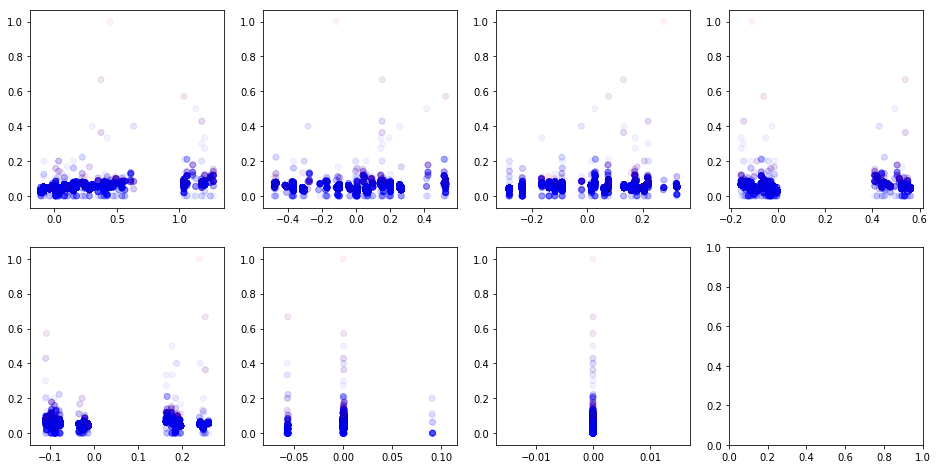

In [18]:
num_pts = 100000
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(Xpca2[:num_pts, 0], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax2.scatter(Xpca2[:num_pts, 1], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax3.scatter(Xpca2[:num_pts, 2], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax4.scatter(Xpca2[:num_pts, 3], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax5.scatter(Xpca2[:num_pts, 4], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax6.scatter(Xpca2[:num_pts, 5], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax7.scatter(Xpca2[:num_pts, 6], y2[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)

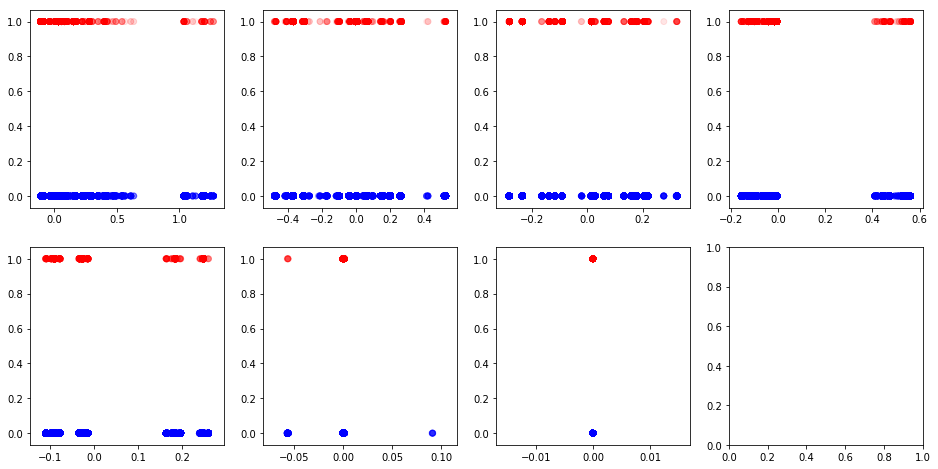

In [19]:
num_pts = 100000
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(Xpca2[:num_pts, 0], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax2.scatter(Xpca2[:num_pts, 1], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax3.scatter(Xpca2[:num_pts, 2], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax4.scatter(Xpca2[:num_pts, 3], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax5.scatter(Xpca2[:num_pts, 4], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax6.scatter(Xpca2[:num_pts, 5], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax7.scatter(Xpca2[:num_pts, 6], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)

In [25]:
jp3 = psjp.JointProbability()
jp3.fit(car_cat_big, target, label='car_cat_big_proba')

In [26]:
res3 = jp3.transform(car_cat_big, label='car_cat_big_proba')

In [27]:
X3 = np.array(car_cat_big)
y3 = np.array(res3)
y = np.array(target)

In [28]:
pca3 = PCA()
Xpca3 = pca3.fit_transform(X3)

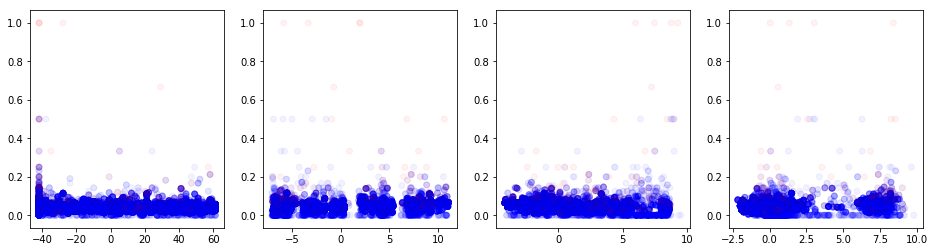

In [33]:
num_pts = 100000
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.scatter(Xpca3[:num_pts, 0], y3[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax2.scatter(Xpca3[:num_pts, 1], y3[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax3.scatter(Xpca3[:num_pts, 2], y3[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax4.scatter(Xpca3[:num_pts, 3], y3[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)

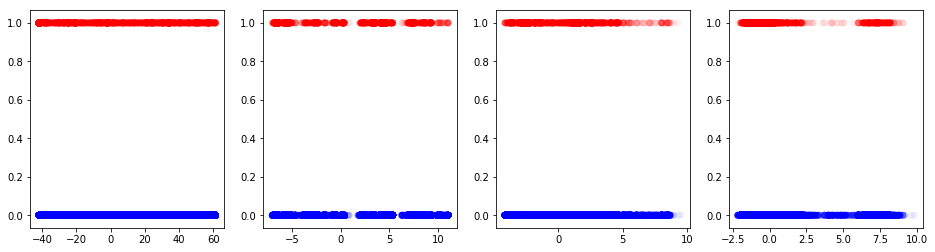

In [40]:
num_pts = 100000
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.scatter(Xpca3[:num_pts, 0], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax2.scatter(Xpca3[:num_pts, 1], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax3.scatter(Xpca3[:num_pts, 2], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)
ax4.scatter(Xpca3[:num_pts, 3], y[:num_pts], c=y[:num_pts], cmap=cm.bwr, alpha=0.05)